# Introduction

In this notebook, we'll assign documents to domains in RDoC with the highest Dice similarity of their brain structures and mental function terms.


# Load the data

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")
import utilities, partition

In [2]:
framework = "rdoc"

## Brain activation coordinates

In [3]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Document-term matrix

In [4]:
dtm_bin = utilities.load_doc_term_matrix(version=190325, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Domain archetypes

In [5]:
from collections import OrderedDict

In [6]:
lists, circuits = utilities.load_framework("rdoc", suffix="_opsim")

In [7]:
words = sorted(list(set(lists["TOKEN"])))
structures = sorted(list(act_bin.columns))
domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

In [8]:
archetypes = pd.DataFrame(0.0, index=words+structures, columns=domains)
for dom in domains:
    for word in lists.loc[lists["DOMAIN"] == dom, "TOKEN"]:
        archetypes.loc[word, dom] = 1.0
    for struct in structures:
        archetypes.loc[struct, dom] = circuits.loc[struct, dom]
archetypes[archetypes > 0.0] = 1.0
print("Term & Structure N={}, Domain N={}".format(
      archetypes.shape[0], archetypes.shape[1]))

Term & Structure N=244, Domain N=6


## Document splits

In [9]:
splits = {}
splits["discovery"] = [int(pmid.strip()) for pmid in open("../data/splits/train.txt")]
splits["replication"] = [int(pmid.strip()) for pmid in open("../data/splits/validation.txt")]
splits["replication"] += [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
for split, pmids in splits.items():
    print("{:12s} N={}".format(split.title(), len(pmids)))

Discovery    N=12708
Replication  N=5447


# Assign documents to systems

In [10]:
from scipy.spatial.distance import cdist

In [11]:
pmids = dtm_bin.index.intersection(act_bin.index)
len(pmids)

18155

In [12]:
dtm_words = dtm_bin.loc[pmids, words]
act_structs = act_bin.loc[pmids, structures]

In [13]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.shape

(18155, 244)

In [14]:
dom_dists = cdist(docs.values, archetypes.values.T, metric="dice")
dom_dists = pd.DataFrame(dom_dists, index=docs.index, columns=domains)
dom_dists.shape

(18155, 6)

In [15]:
doc2dom = {pmid: 0 for pmid in pmids}
for i, pmid in enumerate(pmids):
    doc2dom[pmid] = dom_dists.columns[np.argmin(dom_dists.values[i,:])]

In [16]:
doc2dom_df = pd.Series(doc2dom)
doc2dom_df.to_csv("data/doc2dom_rdoc.csv", header=False)

In [17]:
dom2doc = {dom: [] for dom in domains}
for pmid, dom in doc2dom.items():
    dom2doc[dom].append(pmid)
for dom, dom_pmids in dom2doc.items():
    n_pmids_dis = len(set(dom_pmids).intersection(set(splits["discovery"])))
    n_pmids_rep = len(set(dom_pmids).intersection(set(splits["replication"])))
    print("{:20s} {:5d} discovery {:5d} replication".format(dom, n_pmids_dis, n_pmids_rep))

NEGATIVE_VALENCE      1943 discovery   826 replication
POSITIVE_VALENCE       979 discovery   405 replication
AROUSAL_REGULATION     193 discovery    88 replication
SOCIAL_PROCESSES       761 discovery   310 replication
COGNITIVE_SYSTEMS     4738 discovery  2048 replication
SENSORIMOTOR_SYSTEMS  4094 discovery  1770 replication


# Plot document distances

In [18]:
from style import style
%matplotlib inline

Processing discovery split (N=12708 documents)
----- Computing Dice distance between documents
----- Sorting documents by domain assignment
----- Locating transition points between domains
----- Plotting distances between documents sorted by domain


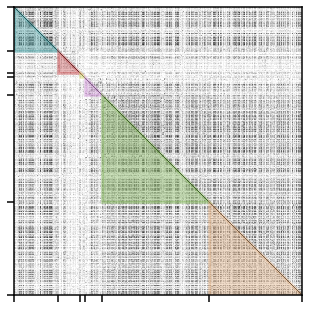

Processing replication split (N=5447 documents)
----- Computing Dice distance between documents
----- Sorting documents by domain assignment
----- Locating transition points between domains
----- Plotting distances between documents sorted by domain


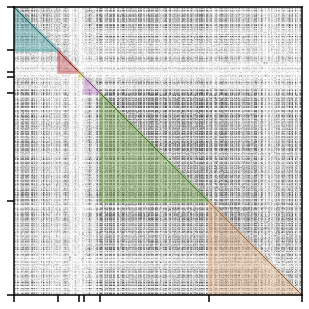

In [19]:
for split, split_pmids in splits.items():
    
    print("Processing {} split (N={} documents)".format(split, len(split_pmids)))
    print("----- Computing Dice distance between documents")
    
    docs_split = docs.loc[split_pmids]
    doc_dists = cdist(docs_split, docs_split, metric="dice")
    doc_dists = pd.DataFrame(doc_dists, index=split_pmids, columns=split_pmids)

    print("----- Sorting documents by domain assignment")
    dom_pmids = []
    for dom in domains:
        dom_pmids += [pmid for pmid, sys in doc2dom.items() if sys == dom and pmid in split_pmids]
    doc_dists = doc_dists[dom_pmids].loc[dom_pmids]

    print("----- Locating transition points between domains")
    transitions = []
    for i, pmid in enumerate(dom_pmids):
        if doc2dom[dom_pmids[i-1]] != doc2dom[pmid]:
            transitions.append(i)
    transitions += [len(split_pmids)]
    
    print("----- Plotting distances between documents sorted by domain")
    partition.plot_partition(framework, doc_dists, transitions, 
                             style.palettes[framework], suffix="_{}".format(split))